In [1]:
#housekeeping and essential imports
import pandas as pd
import os
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1800)
pd.set_option ('display.max_colwidth', 150)
pd.set_option('display.max_columns', 50)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [325]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: None#1px dotted lightgrey;
}

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-dark-palette')
#plt.style.use('seaborn')

In [1]:
%load_ext rpy2.ipython

In [4]:
from multiprocessing import Pool
num_partitions, num_cores = (300, 30)

def parallelize_dataframe(df, func):
    """Multi core processing"""
    print("Parallelizing into {} parts, processsing with {} threads".format(num_partitions, num_cores))
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

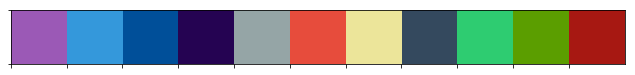

In [5]:
# seaborn setting
flatui = ["#9b59b6", "#3498db", "#004F99", "#250352", "#95a5a6", "#e74c3c", "#ECE59A", "#34495e", "#2ecc71", "#5B9E00", "#A71812"]
sns.palplot(sns.color_palette(flatui))

## Questions on alignments:

**Mapped reads**
- how many are uniquely mapped vs muti-loci mapped?
- **Uniquely Mapped*:
    - Where are they mapped to? what categories?
    - How many of them and % mapped outside of chr1-23?
    - what are teh multi-loci reads?
   
- **unmapped**:
    - where are they mapped to?
    - How many unmapped reads mapped to intergenic region vs introns?

### Reads that uniquely mapped to transcriptome

### Reads that non-uniquely (multi-loci, typically low mapq) mapped to transcriptome

### Reads NOT mapped to transcriptome but can be mapped to whole genome

#### Unmapped reads that are mapped to *genes*

#### Unmapped reads that are mapped *intergenic regions*

In [16]:
import pysam as ps
import glob
import re

In [7]:
pwd

'/gpfs/commons/home/cdai/notebooks'

In [8]:
ES = [str(x) for x in [1,2,5,6,9,10]]
NEU = [str(x) for x in [3,4,7,8,11,12]]
ES = ['Congyi' + x for x in ES]
NEU = ['Congyi' + x for x in NEU]

In [9]:
ES
NEU

['Congyi1', 'Congyi2', 'Congyi5', 'Congyi6', 'Congyi9', 'Congyi10']

['Congyi3', 'Congyi4', 'Congyi7', 'Congyi8', 'Congyi11', 'Congyi12']

## Mapped reads (reads that are mapped to transcriptome)

In [327]:
os.chdir('/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/data/20190730_083004/Fastq/bwa/bwa_gencode_transcript_align/')

In [11]:
bams = glob.glob('Congyi*.sorted.bam')
bams.sort()
bams

['Congyi1.sorted.bam',
 'Congyi10.sorted.bam',
 'Congyi11.sorted.bam',
 'Congyi12.sorted.bam',
 'Congyi2.sorted.bam',
 'Congyi3.sorted.bam',
 'Congyi4.sorted.bam',
 'Congyi5.sorted.bam',
 'Congyi6.sorted.bam',
 'Congyi7.sorted.bam',
 'Congyi8.sorted.bam',
 'Congyi9.sorted.bam']

In [12]:
def bam2df(bams):
    dfs = []
    for bam in bams:
        #sample = bam[0:8].strip('_')
        print("processing {}".format(bam))
        bamfile = ps.AlignmentFile(bam)
        qnames, flags, chroms, starts, ends, mapqs, cigars, XAs = [],[],[],[],[],[],[], []
        df=pd.DataFrame([])
        
        for read in bamfile.fetch():
            qname, flag, chrom, start, end, mapq, cigar, has_XA = read.qname, read.flag, read.reference_name, read.reference_start,read.reference_start + read.query_alignment_length, \
                    read.mapping_quality, read.cigarstring, read.has_tag('XA')
            if has_XA:
                XA = read.get_tag('XA')
            else:
                XA = ''
            if flag != 4 and flag != 20:
                qnames.append(qname)
                flags.append(flag)
                chroms.append(chrom)
                starts.append(start)
                ends.append(end)
                mapqs.append(mapq)
                cigars.append(cigar)
                XAs.append(XA)

        df['qname'] = qnames
        df['flag'] = flags
        df['chr'] = chroms
        df['start'] = starts
        df['end'] = ends
        df['mapqs'] = mapqs
        df['cigars'] = cigars
        df['XA'] = XAs
        df['sample'] = bam

        dfs.append(df)
    
    df2 = pd.concat(dfs)
    return(df2)

In [13]:
mapped_reads = bam2df(bams)

processing Congyi1.sorted.bam
processing Congyi10.sorted.bam
processing Congyi11.sorted.bam
processing Congyi12.sorted.bam
processing Congyi2.sorted.bam
processing Congyi3.sorted.bam
processing Congyi4.sorted.bam
processing Congyi5.sorted.bam
processing Congyi6.sorted.bam
processing Congyi7.sorted.bam
processing Congyi8.sorted.bam
processing Congyi9.sorted.bam


In [14]:
mapped_reads['chr'] = mapped_reads['chr'].str.extract('(ENST[\w\d\._\-]+)\|.+', expand=False)
mapped_reads['XA'] = mapped_reads['XA'].str.extract('(ENST[\w\d\._\-]+)\|.+', expand=False)

In [17]:
mapped_reads['group'] = mapped_reads['sample'].map(lambda x: 'ES' if re.findall('(Congyi\d+)\.+', x)[0] in ES else 'NEU')

In [18]:
mapped_reads.rename(columns={'chr':'transcript_id'}, inplace=True)

In [19]:
mapped_reads.shape
mapped_reads.head(2)

(145141, 10)

,qname,flag,transcript_id,start,end,mapqs,cigars,XA,sample,group
0,M00911:259:000000000-G43JP:1:1102:19844:13568,0,ENST00000416931.1,217,364,0,147M,ENST00000361390.2,Congyi1.sorted.bam,ES
1,M00911:259:000000000-G43JP:1:1104:21921:18019,0,ENST00000416931.1,217,368,0,151M,ENST00000361390.2,Congyi1.sorted.bam,ES


In [20]:
chr1_24 = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',\
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',\
       'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22',\
       'chrX', 'chrY']
chrM = ['chrM']

### uniquely mapped reads

In [21]:
unique_mapped_reads = mapped_reads[mapped_reads.XA.isna()]

In [22]:
unique_mapped_reads.head()

,qname,flag,transcript_id,start,end,mapqs,cigars,XA,sample,group
38,M00911:259:000000000-G43JP:1:1103:23874:16312,0,ENST00000607307.1,1137,1288,37,151M,NaN,Congyi1.sorted.bam,ES
40,M00911:259:000000000-G43JP:1:2101:10399:6850,0,ENST00000615951.4,377,419,0,42M,NaN,Congyi1.sorted.bam,ES
41,M00911:259:000000000-G43JP:1:2104:12742:18560,0,ENST00000481276.1,1936,2034,25,98M,NaN,Congyi1.sorted.bam,ES
49,M00911:259:000000000-G43JP:1:2104:17211:14418,16,ENST00000400919.7,486,612,0,126M,NaN,Congyi1.sorted.bam,ES
50,M00911:259:000000000-G43JP:1:1103:15229:11252,16,ENST00000378536.5,3575,3632,37,57M,NaN,Congyi1.sorted.bam,ES


In [410]:
# uniquely maped reads
unique_mapped_reads.shape[0]
unique_mapped_reads.qname.unique().shape[0]
# uniquely mapped reads / total mapped reads %
unique_mapped_reads.shape[0] / mapped_reads.shape[0]

80367

80367

0.5537167306274589

In [28]:
# categories of uniquely mapped reads
unique_mapped_reads = pd.merge(unique_mapped_reads, transcripts[['transcript_id', 'seqname', 'gene_type', 'gene_name', 'gene_id']], \
         how='inner', on='transcript_id')

In [29]:
unique_mapped_reads.head(2)

,qname,flag,transcript_id,start,end,mapqs,cigars,XA,sample,group,seqname,gene_type,gene_name,gene_id
0,M00911:259:000000000-G43JP:1:1103:23874:16312,0,ENST00000607307.1,1137,1288,37,151M,NaN,Congyi1.sorted.bam,ES,chr1,lncRNA,AL391244.2,ENSG00000272455.1
1,M00911:259:000000000-G43JP:1:2101:10399:6850,0,ENST00000615951.4,377,419,0,42M,NaN,Congyi1.sorted.bam,ES,chr1,protein_coding,CDK11B,ENSG00000248333.8


In [30]:
unique_mapped_reads.groupby(by='gene_type')['qname'].size().sort_values(ascending=False)
unique_mapped_reads.groupby(by='seqname')['qname'].size().sort_values(ascending=False)

gene_type
protein_coding                        73868
lncRNA                                 3350
Mt_rRNA                                1694
processed_pseudogene                    671
TEC                                     189
transcribed_unprocessed_pseudogene      151
transcribed_processed_pseudogene        130
Mt_tRNA                                 127
misc_RNA                                 97
transcribed_unitary_pseudogene           44
unprocessed_pseudogene                   21
scRNA                                    11
snRNA                                     3
pseudogene                                3
unitary_pseudogene                        3
snoRNA                                    2
polymorphic_pseudogene                    1
miRNA                                     1
TR_C_gene                                 1
Name: qname, dtype: int64

seqname
chr12    6307
chr1     6127
chr6     5959
chr2     5582
chr17    5317
chr19    4968
chrM     4613
chr5     4025
chr3     3880
chr11    3664
chrX     3190
chr16    2986
chr8     2829
chr7     2806
chr4     2781
chr10    2285
chr15    2125
chr14    1932
chr20    1931
chr9     1919
chr13    1490
chr18    1435
chr22    1403
chr21     783
chrY       30
Name: qname, dtype: int64

#### Uniquely mapped reads (to transcriptome) read counts by genes

In [31]:
cts_gene_uniq_to_trans = unique_mapped_reads[(unique_mapped_reads.mapqs > 0)].groupby(by=['gene_id', 'gene_name'])['qname'].size().sort_values(ascending=False)
ES_cts_gene_uniq_to_trans = unique_mapped_reads[(unique_mapped_reads.mapqs > 0) & (unique_mapped_reads.group == 'ES')].groupby(by=['group', 'gene_id', 'gene_name'])['qname'].size().sort_values(ascending=False)
NEU_cts_gene_uniq_to_trans = unique_mapped_reads[(unique_mapped_reads.mapqs > 0) & (unique_mapped_reads.group == 'NEU')].groupby(by=['group','gene_id', 'gene_name'])['qname'].size().sort_values(ascending=False)

In [415]:
x.qname.sum()

34383

In [413]:
x = cts_gene_uniq_to_trans.reset_index()
x[x.gene_name.str.contains('MT-')]


,gene_id,gene_name,qname
0,ENSG00000210082.2,MT-RNR2,1310
2,ENSG00000198938.2,MT-CO3,691
3,ENSG00000198899.2,MT-ATP6,662
5,ENSG00000198727.2,MT-CYB,443
6,ENSG00000211459.2,MT-RNR1,384
7,ENSG00000198712.1,MT-CO2,360
9,ENSG00000198886.2,MT-ND4,192
13,ENSG00000198840.2,MT-ND3,124
15,ENSG00000198888.2,MT-ND1,121
18,ENSG00000210151.2,MT-TS1,109


In [32]:
cts_gene_uniq_to_trans.head(20)
ES_cts_gene_uniq_to_trans.head(20)
NEU_cts_gene_uniq_to_trans.head(20)

gene_id             gene_name
ENSG00000210082.2   MT-RNR2      1310
ENSG00000167552.14  TUBA1A       1000
ENSG00000198938.2   MT-CO3        691
ENSG00000198899.2   MT-ATP6       662
ENSG00000087086.15  FTL           461
ENSG00000198727.2   MT-CYB        443
ENSG00000211459.2   MT-RNR1       384
ENSG00000198712.1   MT-CO2        360
ENSG00000005022.6   SLC25A5       201
ENSG00000198886.2   MT-ND4        192
ENSG00000171858.18  RPS21         160
ENSG00000198034.11  RPS4X         126
ENSG00000034510.6   TMSB10        124
ENSG00000198840.2   MT-ND3        124
ENSG00000130741.11  EIF2S3        123
ENSG00000198888.2   MT-ND1        121
ENSG00000213190.3   MLLT11        117
ENSG00000277443.3   MARCKS        113
ENSG00000210151.2   MT-TS1        109
ENSG00000137267.6   TUBB2A        103
Name: qname, dtype: int64

group  gene_id             gene_name
ES     ENSG00000210082.2   MT-RNR2      635
       ENSG00000198899.2   MT-ATP6      369
       ENSG00000198938.2   MT-CO3       321
       ENSG00000087086.15  FTL          303
       ENSG00000167552.14  TUBA1A       265
       ENSG00000211459.2   MT-RNR1      199
       ENSG00000198727.2   MT-CYB       178
       ENSG00000198712.1   MT-CO2       163
       ENSG00000005022.6   SLC25A5      112
       ENSG00000198886.2   MT-ND4       102
       ENSG00000171858.18  RPS21         88
       ENSG00000198840.2   MT-ND3        72
       ENSG00000198034.11  RPS4X         63
       ENSG00000188612.12  SUMO2         61
       ENSG00000034510.6   TMSB10        57
       ENSG00000165502.6   RPL36AL       56
       ENSG00000130741.11  EIF2S3        53
       ENSG00000171314.9   PGAM1         53
       ENSG00000198888.2   MT-ND1        47
       ENSG00000137267.6   TUBB2A        46
Name: qname, dtype: int64

group  gene_id             gene_name
NEU    ENSG00000167552.14  TUBA1A       735
       ENSG00000210082.2   MT-RNR2      675
       ENSG00000198938.2   MT-CO3       370
       ENSG00000198899.2   MT-ATP6      293
       ENSG00000198727.2   MT-CYB       265
       ENSG00000198712.1   MT-CO2       197
       ENSG00000211459.2   MT-RNR1      185
       ENSG00000087086.15  FTL          158
       ENSG00000213190.3   MLLT11        91
       ENSG00000198886.2   MT-ND4        90
       ENSG00000005022.6   SLC25A5       89
       ENSG00000277443.3   MARCKS        83
       ENSG00000157005.4   SST           76
       ENSG00000198888.2   MT-ND1        74
       ENSG00000171858.18  RPS21         72
       ENSG00000130741.11  EIF2S3        70
       ENSG00000131711.15  MAP1B         69
       ENSG00000210151.2   MT-TS1        68
       ENSG00000034510.6   TMSB10        67
       ENSG00000198034.11  RPS4X         63
Name: qname, dtype: int64

In [33]:
unique_mapped_reads[unique_mapped_reads.gene_id == 'ENSG00000001167.14']

,qname,flag,transcript_id,start,end,mapqs,cigars,XA,sample,group,seqname,gene_type,gene_name,gene_id
57040,M00911:259:000000000-G43JP:1:1102:24293:9359,16,ENST00000341376.10,3585,3736,37,151M,NaN,Congyi11.sorted.bam,NEU,chr6,protein_coding,NFYA,ENSG00000001167.14
57041,M00911:259:000000000-G43JP:1:1102:25931:9787,0,ENST00000341376.10,3726,3802,37,76M,NaN,Congyi4.sorted.bam,NEU,chr6,protein_coding,NFYA,ENSG00000001167.14
57042,M00911:259:000000000-G43JP:1:2101:9994:27453,16,ENST00000341376.10,29,99,37,70M,NaN,Congyi8.sorted.bam,NEU,chr6,protein_coding,NFYA,ENSG00000001167.14
57043,M00911:259:000000000-G43JP:1:2102:22016:3952,16,ENST00000341376.10,3567,3639,37,72M,NaN,Congyi8.sorted.bam,NEU,chr6,protein_coding,NFYA,ENSG00000001167.14


#### Compare ES vs. Neville's ES readcounts

In [45]:
stemdata=pd.read_excel('/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/data/RNAseq_human_neurons_stem_cell.xlsx')

In [46]:
ES_stemdata = stemdata['ctrl_StemCell'].sort_values(ascending=False)

In [47]:
ES_stemdata = ES_stemdata.reset_index()

In [48]:
ES_stemdata.head()

,index,ctrl_StemCell
0,EEF1A1,17.376351
1,TMSB4X,16.900372
2,RPL41,16.708217
3,RPS6,16.438755
4,HSP90AB1,16.430288


In [49]:
ES_cts_gene_uniq_to_trans = ES_cts_gene_uniq_to_trans.reset_index()

In [50]:
ES_cts_gene_uniq_to_trans.head(2)

,index,group,gene_id,gene_name,qname
0,0,ES,ENSG00000210082.2,MT-RNR2,635
1,1,ES,ENSG00000198899.2,MT-ATP6,369


In [54]:
ES_stemdata['']

array(['MT-RNR2', 'MT-ATP6', 'MT-CO3', ..., 'STAT5B', 'ALPK3', 'ZNF358'],
      dtype=object)

In [58]:
Shared_genes = [x for x in list(ES_cts_gene_uniq_to_trans.gene_name.unique()) if x in list(ES_stemdata['index'])]

In [60]:
ES_stemdata[ES_stemdata['index'].isin(Shared_genes)].sort_values('index').head()
ES_cts_gene_uniq_to_trans[ES_cts_gene_uniq_to_trans.gene_name.isin(Shared_genes)][['gene_name', 'qname']].sort_values('gene_name').head()

,index,ctrl_StemCell
11140,A1BG,4.480680
3849,AARS,8.604559
3537,AARS2,8.781500
16742,AARSD1,0.979578
298,AASS,12.346631


,gene_name,qname
2476,A1BG,1
119,AARS,16
4088,AARS2,1
2612,AARSD1,1
182,AASS,12


In [61]:
df1 = ES_stemdata[ES_stemdata['index'].isin(Shared_genes)].sort_values('index')
df1['group'] = 'Neville ES'
df1.rename(columns={'index':'x','ctrl_StemCell':'y'}, inplace=True)

In [62]:
df2 = ES_cts_gene_uniq_to_trans[ES_cts_gene_uniq_to_trans.gene_name.isin(Shared_genes)][['gene_name', 'qname']].sort_values('gene_name')
df2['group'] = 'Congyi ES'
df2.rename(columns={'gene_name':'x', 'qname':'y'}, inplace=True)

In [63]:
df1['y_norm'] = df1.y.transform(lambda x: x/x.mean())
df2['y_norm'] = df2.y.transform(lambda x: x/x.mean())

In [287]:
df1['rrank'] = df1.y.transform(lambda x: x.rank(method='max', ascending=False))
df2['rrank'] = df2.y.transform(lambda x: x.rank(method='max', ascending=False))

In [289]:
df1.head()
df2.head()

,x,y,group,y_norm,rrank
11140,A1BG,4.480680,Neville ES,0.574862,3120.0
3849,AARS,8.604559,Neville ES,1.103947,1489.0
3537,AARS2,8.781500,Neville ES,1.126648,1395.0
16742,AARSD1,0.979578,Neville ES,0.125678,3592.0
298,AASS,12.346631,Neville ES,1.584047,150.0


,x,y,group,y_norm,rrank
2476,A1BG,1,Congyi ES,0.293414,3680.0
119,AARS,16,Congyi ES,4.694626,104.0
4088,AARS2,1,Congyi ES,0.293414,3680.0
2612,AARSD1,1,Congyi ES,0.293414,3680.0
182,AASS,12,Congyi ES,3.520970,169.0


In [291]:
df2.sort_values('rrank').head()

,x,y,group,y_norm,rrank
3,FTL,303,Congyi ES,88.904481,1.0
4,TUBA1A,265,Congyi ES,77.754744,2.0
8,SLC25A5,112,Congyi ES,32.862382,3.0
10,RPS21,88,Congyi ES,25.820443,4.0
12,RPS4X,63,Congyi ES,18.485090,5.0


In [292]:
neville_top50_genes = list(df1.sort_values('y', ascending=False)['x'].head(50))
neville_top100_genes = list(df1.sort_values('y', ascending=False)['x'].head(100))
neville_top1000_genes = list(df1.sort_values('y', ascending=False)['x'].head(1000))
congyi_top50_genes = list(df2.sort_values('y', ascending=False)['x'].head(50))
congyi_top100_genes = list(df2.sort_values('y', ascending=False)['x'].head(100))
congyi_top1000_genes = list(df2.sort_values('y', ascending=False)['x'].head(1000))

In [293]:
neville_top50_genes[0:10]
congyi_top50_genes[0:10]

['RPL41',
 'RPS3A',
 'RPL34',
 'RPL7',
 'RPLP1',
 'HSP90AA1',
 'RPS4X',
 'RPL31',
 'CALM2',
 'RPL9']

['FTL',
 'TUBA1A',
 'SLC25A5',
 'RPS21',
 'RPS4X',
 'SUMO2',
 'TMSB10',
 'RPL36AL',
 'EIF2S3',
 'PGAM1']

## Number of genes intersects between two dataset

In [294]:
len([x for x in congyi_top50_genes if x in neville_top50_genes])
a = [x for x in congyi_top50_genes if x in neville_top50_genes]
a

len([x for x in congyi_top100_genes if x in neville_top100_genes])
b=[x for x in congyi_top100_genes if x in neville_top100_genes]
b[0:5]
len([x for x in congyi_top1000_genes if x in neville_top1000_genes])
c=[x for x in congyi_top1000_genes if x in neville_top1000_genes]
c[0:5]

4

['RPS4X', 'SUMO2', 'EIF2S3', 'NDUFA4']

21

['FTL', 'RPS4X', 'SUMO2', 'RPL36AL', 'EIF2S3']

452

['FTL', 'TUBA1A', 'SLC25A5', 'RPS21', 'RPS4X']

In [295]:
#a
[x for x in a if x in MT_genes]
#b
[x for x in b if x in MT_genes]
#c
[x for x in c if x in MT_genes]

[]

[]

[]

In [296]:
[x for x in df1.x if x in MT_genes]
[x for x in df2.x if x in MT_genes]

[]

[]

In [297]:
df2[df2.x.str.contains('MT-')]

,x,y,group,y_norm,rrank


In [321]:
df1.head()
df2.head()

,x,y,group,y_norm,rrank
11140,A1BG,4.480680,Neville ES,0.574862,3120.0
3849,AARS,8.604559,Neville ES,1.103947,1489.0
3537,AARS2,8.781500,Neville ES,1.126648,1395.0
16742,AARSD1,0.979578,Neville ES,0.125678,3592.0
298,AASS,12.346631,Neville ES,1.584047,150.0


,x,y,group,y_norm,rrank
2476,A1BG,1,Congyi ES,0.293414,3680.0
119,AARS,16,Congyi ES,4.694626,104.0
4088,AARS2,1,Congyi ES,0.293414,3680.0
2612,AARSD1,1,Congyi ES,0.293414,3680.0
182,AASS,12,Congyi ES,3.520970,169.0


In [322]:
plot2_top50_df = pd.concat([df1[df1.x.isin(neville_top50_genes)], df2[df2.x.isin(neville_top50_genes)]])
plot2_top50_df.shape
plot2_top50_df.head()

(100, 5)

,x,y,group,y_norm,rrank
41,ACTB,14.723481,Neville ES,1.888992,22.0
24,CALM2,15.181237,Neville ES,1.947721,9.0
65,CKS2,14.264337,Neville ES,1.830085,38.0
64,CYCS,14.282746,Neville ES,1.832447,37.0
36,EIF2S3,14.845350,Neville ES,1.904628,19.0


In [320]:
df1[(df1.x.isin(neville_top50_genes) & (df1.x.isin(congyi_top50_genes)))]
df2[(df2.x.isin(neville_top50_genes) & (df2.x.isin(congyi_top50_genes)))]

,x,y,group,y_norm,rrank
36,EIF2S3,14.845350,Neville ES,1.904628,19.0
39,NDUFA4,14.738945,Neville ES,1.890976,21.0
21,RPS4X,15.239412,Neville ES,1.955185,7.0
67,SUMO2,14.199945,Neville ES,1.821824,39.0


,x,y,group,y_norm,rrank
16,EIF2S3,53,Congyi ES,15.550949,10.0
24,NDUFA4,37,Congyi ES,10.856323,16.0
12,RPS4X,63,Congyi ES,18.485090,5.0
13,SUMO2,61,Congyi ES,17.898262,6.0


In [301]:
plot3_scatter_top50 = pd.merge(df1[(df1.x.isin(neville_top50_genes) & (df1.x.isin(congyi_top50_genes)))][['x','y','y_norm','rrank']], \
                              df2[(df2.x.isin(neville_top50_genes) & (df2.x.isin(congyi_top50_genes)))][['x','y','y_norm','rrank']],\
                              how='inner', on='x', suffixes=('_neville_top50', '_congyi_top50'))
plot3_scatter_top100 = pd.merge(df1[(df1.x.isin(neville_top100_genes) & (df1.x.isin(congyi_top100_genes)))][['x','y','y_norm','rrank']], \
                              df2[(df2.x.isin(neville_top100_genes) & (df2.x.isin(congyi_top100_genes)))][['x','y','y_norm','rrank']],\
                              how='inner', on='x', suffixes=('_neville_top100', '_congyi_top100'))
plot3_scatter_top1000 = pd.merge(df1[(df1.x.isin(neville_top1000_genes) & (df1.x.isin(congyi_top1000_genes)))][['x','y','y_norm','rrank']], \
                              df2[(df2.x.isin(neville_top1000_genes) & (df2.x.isin(congyi_top1000_genes)))][['x','y','y_norm','rrank']],\
                              how='inner', on='x', suffixes=('_neville_top1000', '_congyi_top1000'))

In [302]:
plot2_scatter_top50 = pd.merge(df1[df1.x.isin(neville_top50_genes)][['x', 'y','y_norm','rrank']], df2[df2.x.isin(neville_top50_genes)][['x','y','y_norm','rrank']], \
                               how='inner', on='x', suffixes=('_neville_top50', '_congyi_top50') )
plot2_scatter_top100 = pd.merge(df1[df1.x.isin(neville_top100_genes)][['x','y', 'y_norm', 'rrank']], df2[df2.x.isin(neville_top100_genes)][['x','y','y_norm','rrank']], \
                               how='inner', on='x', suffixes=('_neville_top100', '_congyi_top100') )
plot2_scatter_top1000 = pd.merge(df1[df1.x.isin(neville_top1000_genes)][['x','y', 'y_norm', 'rrank']], df2[df2.x.isin(neville_top1000_genes)][['x','y','y_norm','rrank']], \
                               how='inner', on='x', suffixes=('_neville_top1000', '_congyi_top1000') )

In [319]:
plot2_scatter_top100.tail()
plot3_scatter_top100.tail()

,x,y_neville_top100,y_norm_neville_top100,rrank_neville_top100,y_congyi_top100,y_norm_congyi_top100,rrank_congyi_top100
95,UBA52,13.724566,1.760834,67.0,4,1.173657,873.0
96,UBE2V2,12.936477,1.659723,95.0,5,1.467071,623.0
97,UGP2,13.420849,1.721867,79.0,1,0.293414,3680.0
98,UQCR10,13.504620,1.732615,77.0,6,1.760485,499.0
99,UQCRH,12.884412,1.653043,98.0,1,0.293414,3680.0


,x,y_neville_top100,y_norm_neville_top100,rrank_neville_top100,y_congyi_top100,y_norm_congyi_top100,rrank_congyi_top100
16,RPS4X,15.239412,1.955185,7.0,63,18.485090,5.0
17,RSL24D1,13.137162,1.685471,88.0,17,4.988040,90.0
18,SOX4,13.144060,1.686356,86.0,29,8.509010,27.0
19,SUMO2,14.199945,1.821824,39.0,61,17.898262,6.0
20,TXN,13.692401,1.756707,70.0,23,6.748525,45.0


### For genes that are part of Neville's top 50/100/1000, what are their counts in Congyi's data set?

**Plot2 on normalized read counts**

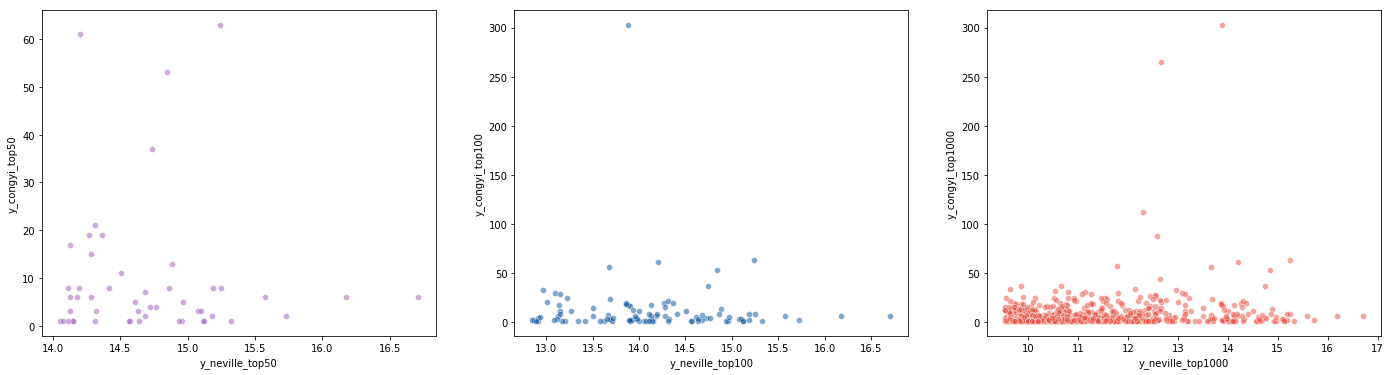

In [308]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(24,6))
sns.scatterplot(x='y_neville_top50', y='y_congyi_top50', data=plot2_scatter_top50, ax=ax1, alpha=0.5, color=flatui[0])
sns.scatterplot(x='y_neville_top100', y='y_congyi_top100', data=plot2_scatter_top100, ax=ax2, alpha=0.5, color=flatui[2])
sns.scatterplot(x='y_neville_top1000', y='y_congyi_top1000', data=plot2_scatter_top1000, ax=ax3, alpha=0.5, color=flatui[5]);

**Plot2 on ranks**

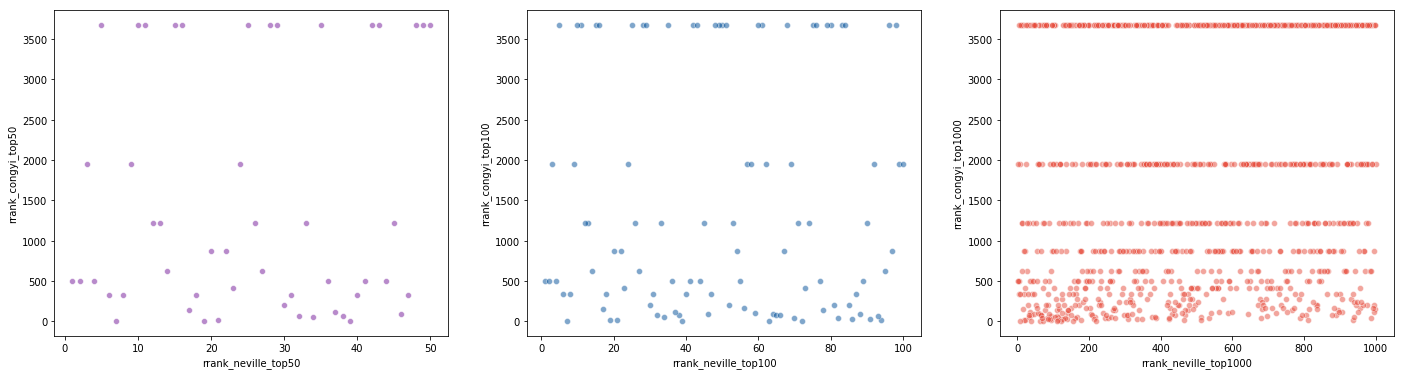

In [305]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(24,6))
sns.scatterplot(x='rrank_neville_top50', y='rrank_congyi_top50', data=plot2_scatter_top50, ax=ax1, alpha=0.7, color=flatui[0])
sns.scatterplot(x='rrank_neville_top100', y='rrank_congyi_top100', data=plot2_scatter_top100, ax=ax2, alpha=0.5, color=flatui[2])
sns.scatterplot(x='rrank_neville_top1000', y='rrank_congyi_top1000', data=plot2_scatter_top1000, ax=ax3, alpha=0.5, color=flatui[5]);

## Shared genes in both dataset (top 50/100/1000)

**Plot3 on normalized counts**

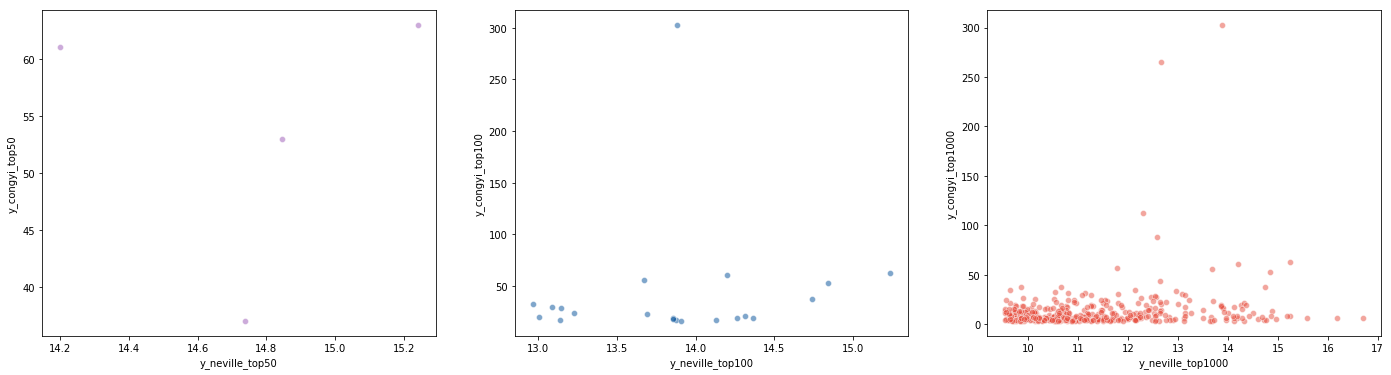

In [306]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(24,6))
sns.scatterplot(x='y_neville_top50', y='y_congyi_top50', data=plot3_scatter_top50, ax=ax1, alpha=0.5, color=flatui[0])
sns.scatterplot(x='y_neville_top100', y='y_congyi_top100', data=plot3_scatter_top100, ax=ax2, alpha=0.5, color=flatui[2])
sns.scatterplot(x='y_neville_top1000', y='y_congyi_top1000', data=plot3_scatter_top1000, ax=ax3, alpha=0.5, color=flatui[5]);

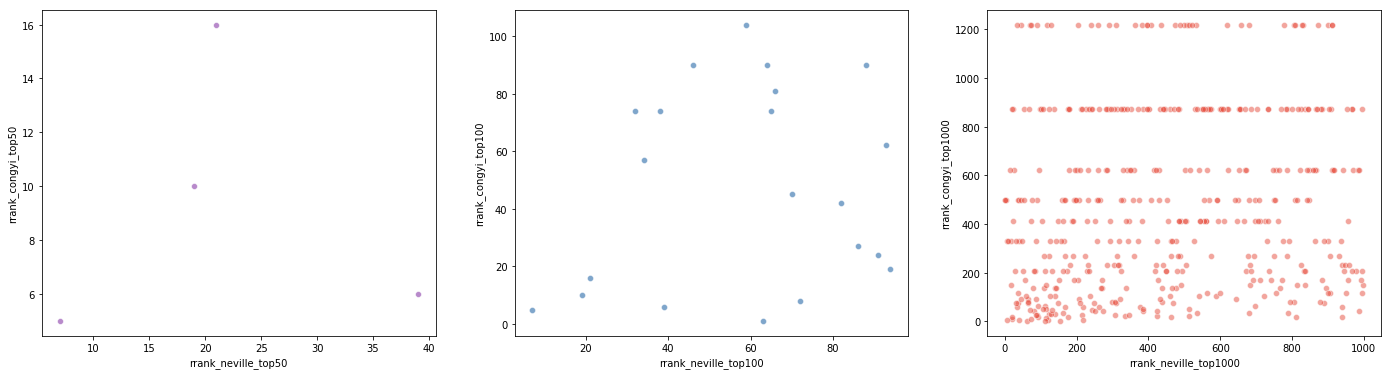

In [307]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(24,6))
sns.scatterplot(x='rrank_neville_top50', y='rrank_congyi_top50', data=plot3_scatter_top50, ax=ax1, alpha=0.7, color=flatui[0])
sns.scatterplot(x='rrank_neville_top100', y='rrank_congyi_top100', data=plot3_scatter_top100, ax=ax2, alpha=0.5, color=flatui[2])
sns.scatterplot(x='rrank_neville_top1000', y='rrank_congyi_top1000', data=plot3_scatter_top1000, ax=ax3, alpha=0.5, color=flatui[5]);

Church's data set

### multi-loci mapped reads

In [220]:
multi_mapped_reads = mapped_reads[~mapped_reads.XA.isna()]

In [323]:
multi_mapped_reads.head(2)

NameError: name 'multi_mapped_reads' is not defined

In [222]:
# multi loci mapped reads
multi_mapped_reads.shape[0]
# multi loci mapped reads / total mapped reads %
multi_mapped_reads.shape[0] / mapped_reads.shape[0]

64774

0.4462832693725412

In [223]:
# categories of uniquely mapped reads
multi_mapped_reads = pd.merge(multi_mapped_reads, transcripts[['transcript_id', 'seqname', 'gene_type', 'gene_name', 'gene_id']], \
         how='inner', on='transcript_id')

In [224]:
multi_mapped_reads.head(2)

,qname,flag,transcript_id,start,end,mapqs,cigars,XA,sample,seqname,gene_type,gene_name,gene_id
0,M00911:259:000000000-G43JP:1:1102:19844:13568,0,ENST00000416931.1,217,364,0,147M,ENST00000361390.2,Congyi1.sorted.bam,chr1,unprocessed_pseudogene,MTND1P23,ENSG00000225972.1
1,M00911:259:000000000-G43JP:1:1104:21921:18019,0,ENST00000416931.1,217,368,0,151M,ENST00000361390.2,Congyi1.sorted.bam,chr1,unprocessed_pseudogene,MTND1P23,ENSG00000225972.1


In [225]:
multi_mapped_reads.groupby('gene_type')['qname'].size().sort_values(ascending=False)
multi_mapped_reads.groupby('seqname')['qname'].size().sort_values(ascending=False)

gene_type
protein_coding                        62242
lncRNA                                 1683
unprocessed_pseudogene                  264
transcribed_processed_pseudogene        162
processed_pseudogene                    122
transcribed_unprocessed_pseudogene      107
TEC                                      65
Mt_rRNA                                  48
polymorphic_pseudogene                   24
misc_RNA                                 23
transcribed_unitary_pseudogene           18
scRNA                                     8
unitary_pseudogene                        3
rRNA                                      2
snoRNA                                    1
TR_V_gene                                 1
pseudogene                                1
Name: qname, dtype: int64

seqname
chr1     7331
chr2     4745
chr12    4651
chr5     3568
chr6     3548
chr17    3374
chr9     3280
chr19    3276
chr3     3238
chr7     3078
chrX     3073
chr11    3015
chr8     2546
chr4     2169
chr15    2106
chr16    2054
chr10    1940
chr14    1913
chr20    1540
chr22    1157
chr13     955
chr18     892
chrM      776
chr21     494
chrY       55
Name: qname, dtype: int64

**Total number of reads mapped to Mitochondria within mapped reads**

In [226]:
# total reads mapped to chrM within mapped reads
total_chrM_transcripts = unique_mapped_reads.groupby(by='seqname')['qname'].size()['chrM'] + multi_mapped_reads.groupby('seqname')['qname'].size()['chrM']
total_chrM_transcripts
total_chrM_transcripts / mapped_reads.shape[0]

5389

0.03712941208893421

---

## Unmapped reads (reads not mapped to transcriptome)

In [227]:
os.chdir('/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/data/20190730_083004/Fastq/unmapped/')

In [228]:
pwd

'/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/data/20190730_083004/Fastq/unmapped'

In [229]:
bams2 = glob.glob('*.sorted.bam')
bams2.sort()
bams2

['All.unmap.sorted.bam']

In [230]:
# NOTE This is not the full set of reads unmapped to transcriptome. Reads that are not mapped (flag=4/20) to genome are not included
genome_reads = bam2df(bams2)

processing All.unmap.sorted.bam


In [244]:
genome_reads.shape
genome_reads.head(2)
genome_reads.tail(2)

(49900, 9)

,qname,flag,chr,start,end,mapqs,cigars,XA,sample
0,M00911:259:000000000-G43JP:1:2101:19010:15067,0,chr1,51747,51864,0,117M,"chr15,-101939081,117M,4;",All.unmap.sorted.bam
1,M00911:259:000000000-G43JP:1:2101:10617:21155,0,chr1,92589,92657,37,68M,,All.unmap.sorted.bam


,qname,flag,chr,start,end,mapqs,cigars,XA,sample
49898,M00911:259:000000000-G43JP:1:2104:14860:29237,16,KI270751.1,88106,88247,0,141M,"GL000214.1,+15828,141M,5;",All.unmap.sorted.bam
49899,M00911:259:000000000-G43JP:1:1102:18597:14109,0,KI270755.1,5618,5769,0,151M,"chr4,-189697234,151M,3;",All.unmap.sorted.bam


In [246]:
genome_reads['chr'].unique()

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22',
       'chrX', 'chrY', 'chrM', 'GL000009.2', 'GL000194.1', 'GL000195.1',
       'GL000205.2', 'GL000214.1', 'GL000216.2', 'GL000218.1',
       'GL000219.1', 'GL000220.1', 'GL000221.1', 'GL000224.1',
       'GL000225.1', 'KI270442.1', 'KI270467.1', 'KI270706.1',
       'KI270712.1', 'KI270717.1', 'KI270719.1', 'KI270725.1',
       'KI270727.1', 'KI270728.1', 'KI270731.1', 'KI270733.1',
       'KI270741.1', 'KI270742.1', 'KI270743.1', 'KI270746.1',
       'KI270748.1', 'KI270751.1', 'KI270755.1'], dtype=object)

In [249]:
# total number of reads mapped to mitochondria
genome_reads[genome_reads['chr'] == 'chrM'].shape[0]
# total number of reads mapped to non chromosome 1 - Y
genome_reads[~genome_reads['chr'].isin(chr1_24)].shape[0]

484

686

### reads that are uniquely mapped to genome (but not transcriptome)

In [240]:
genome_unique_map_reads = genome_reads[genome_reads.XA.str.len() < 1]

In [253]:
genome_unique_map_reads.shape
genome_unique_map_reads.head(5)

(47958, 9)

,qname,flag,chr,start,end,mapqs,cigars,XA,sample
1,M00911:259:000000000-G43JP:1:2101:10617:21155,0,chr1,92589,92657,37,68M,,All.unmap.sorted.bam
2,M00911:259:000000000-G43JP:1:2104:25432:17640,0,chr1,101223,101335,0,112M,,All.unmap.sorted.bam
3,M00911:259:000000000-G43JP:1:2101:23171:16911,16,chr1,272011,272162,0,151M,,All.unmap.sorted.bam
5,M00911:259:000000000-G43JP:1:2103:14539:8854,16,chr1,490827,490978,0,151M,,All.unmap.sorted.bam
36,M00911:259:000000000-G43JP:1:1102:19896:18134,0,chr1,632639,632693,25,54M,,All.unmap.sorted.bam


In [ ]:
# How many mapped to chrM?
genome_unique_map_reads

### reads that are multi-loci mapped to genome (but not transcriptome)

In [256]:
genome_multi_map_reads = genome_reads[genome_reads.XA.str.len() > 1]
genome_multi_map_reads.shape
genome_multi_map_reads.tail()

(1942, 9)

,qname,flag,chr,start,end,mapqs,cigars,XA,sample
49890,M00911:259:000000000-G43JP:1:2101:20093:18238,16,KI270742.1,81675,81776,0,101M,"GL000221.1,-51740,101M,0;chr21,+9353239,101M,0;",All.unmap.sorted.bam
49891,M00911:259:000000000-G43JP:1:2101:21643:25026,0,KI270742.1,82234,82312,0,78M,"chr21,-9352703,78M,0;GL000221.1,+52298,78M,1;",All.unmap.sorted.bam
49893,M00911:259:000000000-G43JP:1:1103:15650:10532,0,KI270743.1,57078,57223,20,145M,"chr22,+12086776,145M,1;GL000008.2,+72218,145M,1;",All.unmap.sorted.bam
49898,M00911:259:000000000-G43JP:1:2104:14860:29237,16,KI270751.1,88106,88247,0,141M,"GL000214.1,+15828,141M,5;",All.unmap.sorted.bam
49899,M00911:259:000000000-G43JP:1:1102:18597:14109,0,KI270755.1,5618,5769,0,151M,"chr4,-189697234,151M,3;",All.unmap.sorted.bam


## Unmapped reads

*Total 257474 reads aligned to transcriptome, 140183 are aligned, 117291 unaligned, 80368 uniquely mapped.*

Within unaligned reads, 49900 are aligned to genome, 47958 are uniquely aligned to whole genome.

Within unaligned reads that are mapped to genome:
    - 15434 reads are intergenic (13% of all unaligned to transcriptome)
    - 32712 reads are introns (28% of all unaligned to transcriptome)
    - 67391 reads cannot be mapped to neither transcriptome nor genome (57% of all unaligned to transcriptome)


In [371]:
intron_intergenic = pd.read_csv('/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/data/20190730_083004/Fastq/unmapped/unmap_intersect_intron_intergenic.bed',\
                               sep='\t', header=None)

In [373]:
intron_intergenic.rename(columns={0:'chrom', 1:'start', 2:'end', 3:'qname', 4:'mapq', 5:'strand', 6:'cigar', 11:'feature'}, inplace=True)

In [374]:
intron_intergenic.head()

,chrom,start,end,qname,mapq,strand,cigar,7,8,9,10,feature,12
0,chr1,51747,51864,M00911:259:000000000-G43JP:1:2101:19010:15067,0,+,117M,1,chr1,36081,52473,intergenic,117
1,chr1,92589,92657,M00911:259:000000000-G43JP:1:2101:10617:21155,37,+,68M,2,chr1,92240,110953,ENSG00000238009.6,68
2,chr1,101223,101335,M00911:259:000000000-G43JP:1:2104:25432:17640,0,+,112M,2,chr1,92240,110953,ENSG00000238009.6,112
3,chr1,272011,272162,M00911:259:000000000-G43JP:1:2101:23171:16911,0,-,151M,2,chr1,268816,289266,ENSG00000228463.10,151
4,chr1,275679,275792,M00911:259:000000000-G43JP:1:2102:23568:18695,20,-,113M,2,chr1,268816,289266,ENSG00000228463.10,113


In [378]:
# how many reads are aligned to intergenic region?
intron_intergenic[intron_intergenic['feature'] == 'intergenic'].shape
intron_intergenic[intron_intergenic['feature'] == 'intergenic'].qname.unique().shape
intron_intergenic[intron_intergenic['feature'] == 'intergenic'].head()

(15434, 13)

(15434,)

,chrom,start,end,qname,mapq,strand,cigar,7,8,9,10,feature,12
0,chr1,51747,51864,M00911:259:000000000-G43JP:1:2101:19010:15067,0,+,117M,1,chr1,36081,52473,intergenic,117
21,chr1,883123,883274,M00911:259:000000000-G43JP:1:2103:9730:13056,37,+,151M,1,chr1,877234,904834,intergenic,151
22,chr1,883190,883341,M00911:259:000000000-G43JP:1:1101:15565:21059,37,+,151M,1,chr1,877234,904834,intergenic,151
23,chr1,883190,883341,M00911:259:000000000-G43JP:1:2103:5234:22126,37,+,151M,1,chr1,877234,904834,intergenic,151
24,chr1,883200,883351,M00911:259:000000000-G43JP:1:1104:7098:10907,37,+,151M,1,chr1,877234,904834,intergenic,151


In [380]:
# how many reads are aligned to introns?
intron_intergenic[intron_intergenic['feature'] != 'intergenic'].shape
intron_intergenic[intron_intergenic['feature'] != 'intergenic'].qname.unique().shape
intron_intergenic[intron_intergenic['feature'] != 'intergenic'].tail()

(36838, 13)

(32712,)

,chrom,start,end,qname,mapq,strand,cigar,7,8,9,10,feature,12
52178,chrY,2627120,2627271,M00911:259:000000000-G43JP:1:1101:12954:7874,0,+,151M,2,chrY,2626642,2637974,ENSG00000223773.7_PAR_Y,151
52179,chrY,2710888,2711002,M00911:259:000000000-G43JP:1:2103:11317:8539,0,-,114M,2,chrY,2692253,2714422,ENSG00000002586.20_PAR_Y,114
52182,chrY,5323859,5323982,M00911:259:000000000-G43JP:1:1101:18568:15101,0,-,123M,2,chrY,5208069,5337745,ENSG00000099715.14,123
52183,chrY,5519964,5520047,M00911:259:000000000-G43JP:1:1104:8708:22358,0,+,83M,2,chrY,5501255,5573145,ENSG00000099715.14,83
52186,chrY,13845942,13846011,M00911:259:000000000-G43JP:1:1104:8816:3906,0,-,69M,2,chrY,13790966,13854444,ENSG00000241859.7,69


In [400]:
# which genes have the most intron retained?
introns = intron_intergenic[intron_intergenic['feature'] != 'intergenic']
mostintrons = introns.groupby('feature')['qname'].size().sort_values(ascending=False)
mostintrons.head(10)

feature
ENSG00000287001.1     78
ENSG00000236780.7     72
ENSG00000280441.3     45
ENSG00000078328.20    40
ENSG00000278996.1     40
ENSG00000158321.17    40
ENSG00000174469.23    37
ENSG00000153707.17    36
ENSG00000144724.20    34
ENSG00000105426.16    33
Name: qname, dtype: int64

In [409]:
gtf[(gtf.gene_id.isin(mostintrons.head(10).index)) & (gtf.feature == 'gene')]

,seqname,source,feature,start,end,score,strand,frame,gene_id,gene_type,gene_name,level,hgnc_id,havana_gene,transcript_id,transcript_type,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
319076,chr2,HAVANA,gene,67123357,67397980,NaN,-,0,ENSG00000236780.7,lncRNA,LINC01829,2,HGNC:52635,OTTHUMG00000152856.5,,,,,,,,,,,
557423,chr3,HAVANA,gene,61561569,62297609,NaN,+,0,ENSG00000144724.20,protein_coding,PTPRG,2,HGNC:9671,OTTHUMG00000158660.2,,,,,,,,,,,
1088010,chr7,HAVANA,gene,69598296,70793495,NaN,+,0,ENSG00000158321.17,protein_coding,AUTS2,2,HGNC:14262,OTTHUMG00000023865.11,,,,,,,,,,,
1166141,chr7,HAVANA,gene,146116002,148420998,NaN,+,0,ENSG00000174469.23,protein_coding,CNTNAP2,1,HGNC:13830,OTTHUMG00000152743.11,,,,,"ncRNA_host,overlapping_locus",,,,,,
1291009,chr9,HAVANA,gene,8314246,10612723,NaN,-,0,ENSG00000153707.17,protein_coding,PTPRD,2,HGNC:9668,OTTHUMG00000021005.6,,,,,overlapping_locus,,,,,,
2112658,chr16,HAVANA,gene,5239802,7713338,NaN,+,0,ENSG00000078328.20,protein_coding,RBFOX1,1,HGNC:18222,OTTHUMG00000129551.12,,,,,ncRNA_host,,,,,,
2463617,chr19,HAVANA,gene,5158495,5340803,NaN,-,0,ENSG00000105426.16,protein_coding,PTPRS,2,HGNC:9681,OTTHUMG00000180325.5,,,,,,,,,,,
2588979,chr19,HAVANA,gene,50136859,50148230,NaN,-,0,ENSG00000287001.1,lncRNA,AC010624.5,2,,OTTHUMG00000195792.1,,,,,,,,,,,
2685979,chr21,HAVANA,gene,8197620,8227646,NaN,+,0,ENSG00000278996.1,lncRNA,FP671120.2,2,,OTTHUMG00000189417.1,,,,,ncRNA_host,,,,,,
2686030,chr21,HAVANA,gene,8380643,8454792,NaN,+,0,ENSG00000280441.3,lncRNA,FP236383.1,2,,OTTHUMG00000189419.3,,,,,ncRNA_host,,,,,,


## GTF

In [24]:
import gtfparse as gpar

In [25]:
gtf = gpar.read_gtf('/gpfs/commons/groups/sanjana_lab/cdai/ref_genome/gencode.v31.primary_assembly.annotation.gtf')

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'hgnc_id', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'tag', 'havana_transcript', 'exon_number', 'exon_id', 'ont', 'protein_id', 'ccdsid']


In [329]:
gtf.to_csv('/gpfs/commons/groups/sanjana_lab/cdai/ref_genome/gencode.v31.primary_assembly.annotation.pandas.df.gtf', sep='\t', header=True, index=False)

In [328]:
gtf[gtf.gene_id == 'ENSG00000186092.6']

,seqname,source,feature,start,end,score,strand,frame,gene_id,gene_type,gene_name,level,hgnc_id,havana_gene,transcript_id,transcript_type,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
57,chr1,HAVANA,gene,65419,71585,NaN,+,0,ENSG00000186092.6,protein_coding,OR4F5,2,HGNC:14825,OTTHUMG00000001094.4,,,,,,,,,,,
58,chr1,HAVANA,transcript,65419,71585,NaN,+,0,ENSG00000186092.6,protein_coding,OR4F5,2,HGNC:14825,OTTHUMG00000001094.4,ENST00000641515.2,protein_coding,OR4F5-202,,"RNA_Seq_supported_partial,basic",OTTHUMT00000003223.4,,,,ENSP00000493376.2,
59,chr1,HAVANA,exon,65419,65433,NaN,+,0,ENSG00000186092.6,protein_coding,OR4F5,2,HGNC:14825,OTTHUMG00000001094.4,ENST00000641515.2,protein_coding,OR4F5-202,,"RNA_Seq_supported_partial,basic",OTTHUMT00000003223.4,1,ENSE00003812156.1,,ENSP00000493376.2,
60,chr1,HAVANA,exon,65520,65573,NaN,+,0,ENSG00000186092.6,protein_coding,OR4F5,2,HGNC:14825,OTTHUMG00000001094.4,ENST00000641515.2,protein_coding,OR4F5-202,,"RNA_Seq_supported_partial,basic",OTTHUMT00000003223.4,2,ENSE00003813641.1,,ENSP00000493376.2,
61,chr1,HAVANA,CDS,65565,65573,NaN,+,0,ENSG00000186092.6,protein_coding,OR4F5,2,HGNC:14825,OTTHUMG00000001094.4,ENST00000641515.2,protein_coding,OR4F5-202,,"RNA_Seq_supported_partial,basic",OTTHUMT00000003223.4,2,ENSE00003813641.1,,ENSP00000493376.2,
62,chr1,HAVANA,start_codon,65565,65567,NaN,+,0,ENSG00000186092.6,protein_coding,OR4F5,2,HGNC:14825,OTTHUMG00000001094.4,ENST00000641515.2,protein_coding,OR4F5-202,,"RNA_Seq_supported_partial,basic",OTTHUMT00000003223.4,2,ENSE00003813641.1,,ENSP00000493376.2,
63,chr1,HAVANA,exon,69037,71585,NaN,+,0,ENSG00000186092.6,protein_coding,OR4F5,2,HGNC:14825,OTTHUMG00000001094.4,ENST00000641515.2,protein_coding,OR4F5-202,,"RNA_Seq_supported_partial,basic",OTTHUMT00000003223.4,3,ENSE00003813949.1,,ENSP00000493376.2,
64,chr1,HAVANA,CDS,69037,70005,NaN,+,0,ENSG00000186092.6,protein_coding,OR4F5,2,HGNC:14825,OTTHUMG00000001094.4,ENST00000641515.2,protein_coding,OR4F5-202,,"RNA_Seq_supported_partial,basic",OTTHUMT00000003223.4,3,ENSE00003813949.1,,ENSP00000493376.2,
65,chr1,HAVANA,stop_codon,70006,70008,NaN,+,0,ENSG00000186092.6,protein_coding,OR4F5,2,HGNC:14825,OTTHUMG00000001094.4,ENST00000641515.2,protein_coding,OR4F5-202,,"RNA_Seq_supported_partial,basic",OTTHUMT00000003223.4,3,ENSE00003813949.1,,ENSP00000493376.2,
66,chr1,HAVANA,UTR,65419,65433,NaN,+,0,ENSG00000186092.6,protein_coding,OR4F5,2,HGNC:14825,OTTHUMG00000001094.4,ENST00000641515.2,protein_coding,OR4F5-202,,"RNA_Seq_supported_partial,basic",OTTHUMT00000003223.4,1,ENSE00003812156.1,,ENSP00000493376.2,


In [47]:
chroms = gtf[gtf.seqname.str.len() < 6].seqname.unique()

In [48]:
chroms

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22',
       'chrX', 'chrY', 'chrM'], dtype=object)

In [49]:
gtf_short = gtf[gtf.seqname.isin(chroms)]

In [26]:
transcripts = gtf[gtf.feature == 'transcript'][['seqname', 'source', 'feature', 'start', 'end', 'strand', 'gene_id', 'gene_type',\
                                               'gene_name', 'transcript_id']].drop_duplicates()

In [121]:
transcripts.seqname.unique()

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22',
       'chrX', 'chrY', 'chrM', 'GL000009.2', 'GL000194.1', 'GL000195.1',
       'GL000205.2', 'GL000213.1', 'GL000216.2', 'GL000218.1',
       'GL000219.1', 'GL000220.1', 'GL000225.1', 'KI270442.1',
       'KI270711.1', 'KI270713.1', 'KI270721.1', 'KI270726.1',
       'KI270727.1', 'KI270728.1', 'KI270731.1', 'KI270733.1',
       'KI270734.1', 'KI270744.1', 'KI270750.1'], dtype=object)

In [59]:
genes = gtf[gtf.feature == 'gene'][['seqname', 'source', 'feature', 'start', 'end', 'strand', 'gene_id', 'gene_type',\
                                               'gene_name']].drop_duplicates()

In [61]:
genes.head(2)
genes.shape

,seqname,source,feature,start,end,strand,gene_id,gene_type,gene_name
0,chr1,HAVANA,gene,11869,14409,+,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1
12,chr1,HAVANA,gene,14404,29570,-,ENSG00000227232.5,unprocessed_pseudogene,WASH7P


(60662, 9)

In [268]:
gtf.head()

,seqname,source,feature,start,end,score,strand,frame,gene_id,gene_type,gene_name,level,hgnc_id,havana_gene,transcript_id,transcript_type,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
0,chr1,HAVANA,gene,11869,14409,NaN,+,0,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,,,,,,,,,,,
1,chr1,HAVANA,transcript,11869,14409,NaN,+,0,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,ENST00000456328.2,lncRNA,DDX11L1-202,1,basic,OTTHUMT00000362751.1,,,,,
2,chr1,HAVANA,exon,11869,12227,NaN,+,0,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,ENST00000456328.2,lncRNA,DDX11L1-202,1,basic,OTTHUMT00000362751.1,1,ENSE00002234944.1,,,
3,chr1,HAVANA,exon,12613,12721,NaN,+,0,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,ENST00000456328.2,lncRNA,DDX11L1-202,1,basic,OTTHUMT00000362751.1,2,ENSE00003582793.1,,,
4,chr1,HAVANA,exon,13221,14409,NaN,+,0,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,ENST00000456328.2,lncRNA,DDX11L1-202,1,basic,OTTHUMT00000362751.1,3,ENSE00002312635.1,,,


In [263]:
gtf.feature.unique()

array(['gene', 'transcript', 'exon', 'CDS', 'start_codon', 'stop_codon',
       'UTR', 'Selenocysteine'], dtype=object)

In [270]:
MT_genes = list(gtf[(gtf.feature=='gene') & (gtf.seqname=='chrM')].gene_name)

In [357]:
exons = gtf[gtf.feature == 'exon'][['seqname', 'start', 'end', 'exon_id', 'gene_id', 'strand']].drop_duplicates()

In [358]:
genes = gtf[gtf.feature == 'gene'][['seqname', 'start', 'end', 'gene_id', 'score', 'strand']].drop_duplicates()

In [368]:
exons[['seqname','start','end','exon_id']].to_csv('exons.bed', sep='\t', header=False, index=False)
#genes[['seqname','start','end','gene_id']].to_csv('genes.bed', sep='\t', header=False, index=False)

In [359]:
exons.head()
genes.head()

,seqname,start,end,exon_id,gene_id,strand
2,chr1,11869,12227,ENSE00002234944.1,ENSG00000223972.5,+
3,chr1,12613,12721,ENSE00003582793.1,ENSG00000223972.5,+
4,chr1,13221,14409,ENSE00002312635.1,ENSG00000223972.5,+
6,chr1,12010,12057,ENSE00001948541.1,ENSG00000223972.5,+
7,chr1,12179,12227,ENSE00001671638.2,ENSG00000223972.5,+


,seqname,start,end,gene_id,score,strand
0,chr1,11869,14409,ENSG00000223972.5,NaN,+
12,chr1,14404,29570,ENSG00000227232.5,NaN,-
25,chr1,17369,17436,ENSG00000278267.1,NaN,-
28,chr1,29554,31109,ENSG00000243485.5,NaN,+
36,chr1,30366,30503,ENSG00000284332.1,NaN,+


In [362]:
genes.head()

,seqname,start,end,gene_id,score,strand,size
0,chr1,11869,14409,ENSG00000223972.5,NaN,+,2540
12,chr1,14404,29570,ENSG00000227232.5,NaN,-,15166
25,chr1,17369,17436,ENSG00000278267.1,NaN,-,67
28,chr1,29554,31109,ENSG00000243485.5,NaN,+,1555
36,chr1,30366,30503,ENSG00000284332.1,NaN,+,137


In [361]:
genes['size'] = genes.end - genes.start

In [367]:
genes[['gene_id', 'size']].to_csv('hg38_gene_size.txt', sep='\t', header=False, index=False)

In [365]:
genes['seqname'].sort_values().unique()

array(['GL000009.2', 'GL000194.1', 'GL000195.1', 'GL000205.2',
       'GL000213.1', 'GL000216.2', 'GL000218.1', 'GL000219.1',
       'GL000220.1', 'GL000225.1', 'KI270442.1', 'KI270711.1',
       'KI270713.1', 'KI270721.1', 'KI270726.1', 'KI270727.1',
       'KI270728.1', 'KI270731.1', 'KI270733.1', 'KI270734.1',
       'KI270744.1', 'KI270750.1', 'chr1', 'chr10', 'chr11', 'chr12',
       'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19',
       'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6',
       'chr7', 'chr8', 'chr9', 'chrM', 'chrX', 'chrY'], dtype=object)

In [5]:
%%R
install.packages('ggplot2')

R[write to console]: Installing package into ‘/gpfs/commons/home/cdai/R/x86_64-redhat-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)

R[write to console]: Error in contrib.url(repos, type) : 
  trying to use CRAN without setting a mirror
Calls: <Anonymous> ... withVisible -> install.packages -> grep -> contrib.url




Error in contrib.url(repos, type) : 
  trying to use CRAN without setting a mirror
Calls: <Anonymous> ... withVisible -> install.packages -> grep -> contrib.url


fastq extraction

In [3]:
os.chdir('/c/groups/sanjana_lab/cdai/TFscreen/data/20190816/original_fastq/')

In [4]:
ls *.fastq

toy.fastq


In [122]:
import sys

In [129]:
with open('Undetermined_fastq/barcodes_to_remove.txt') as f_barcodes: # firt argument for the file of barcode removal list
    barcodes = f_barcodes.readlines()
    barcodes = [s.strip() for s in barcodes]

In [130]:
barcodes

['GGGGGGGG+AGATCTCG', 'GGGGGGGG+NGATCTCG', 'GGGGGGGG+GGGGGGGG']

In [139]:
%%file Undetermined_fastq/extractSeq.sh
#!/bin/bash

barcode=$1
inFASTQ=$2
outFASTQ=$3

module remove python
module load python/3.7.1

echo "Started at $(date)" &>> log
echo "python xfastq.py $barcode $inFASTQ $outFASTQ" $>> log
python xfastq.py $barcode $inFASTQ $outFASTQ
echo "Ended at $(date)" &>> log

Overwriting Undetermined_fastq/extractSeq.sh


In [ ]:
# %load Undetermined_fastq/xfastq.py

# Chao Dai
# remove fastq sequences
# How to: python xfastq.py [barcode to remove list file] [input fastq] [output fastq]

import sys

print("python {} {} {} {}".format(sys.argv[0], sys.argv[1], sys.argv[2], sys.argv[3]))

with open(sys.argv[1]) as f_barcodes: # firt argument for the file of barcode removal list
    barcodes = f_barcodes.readlines()
    barcodes = [s.strip() for s in barcodes] # remove hidden characters

outFile = open(sys.argv[3], 'w') # output file
outFile.truncate()

with open(sys.argv[2]) as fq: # input fastq file
    line = fq.readline()
    cnt = 1
    while line:
        if cnt % 4 == 1:
            barcode = line.strip()[-17:]
            L1 = line.strip()
            if barcode not in barcodes:
                _ = outFile.write("{}\n".format(L1))
        if cnt % 4 == 2 and barcode not in barcodes:
            L2 = line.strip()
            _ = outFile.write("{}\n".format(L2))
        if cnt % 4 == 3 and barcode not in barcodes:
            L3 = line.strip()
            _ = outFile.write("{}\n".format(L3))
        if cnt % 4 == 0 and barcode not in barcodes:
            L4 = line.strip()
            _ = outFile.write("{}\n".format(L4))
        
        line = fq.readline()
        cnt +=1

outFile.close()

In [149]:
%%file Undetermined_fastq/removePolyG.py
# Chao Dai
# remove fastq sequences that have GGGGGGGG in barcode (in readname)
# How to: python removePolyG.py [input fastq] [output fastq]

import sys

print("python {} {} {}".format(sys.argv[0], sys.argv[1], sys.argv[2]))

outFile = open(sys.argv[2], 'w') # output file
outFile.truncate()

with open(sys.argv[1]) as fq: # input fastq file
    line = fq.readline()
    cnt = 1
    while line:
        if cnt % 4 == 1:
            barcode = line.strip()[-17:]
            L1 = line.strip()
            if 'GGGGGGGG' not in barcode:
                _ = outFile.write("{}\n".format(L1))
        if cnt % 4 == 2 and 'GGGGGGGG' not in barcode:
            L2 = line.strip()
            _ = outFile.write("{}\n".format(L2))
        if cnt % 4 == 3 and 'GGGGGGGG' not in barcode:
            L3 = line.strip()
            _ = outFile.write("{}\n".format(L3))
        if cnt % 4 == 0 and 'GGGGGGGG' not in barcode:
            L4 = line.strip()
            _ = outFile.write("{}\n".format(L4))
        
        line = fq.readline()
        cnt +=1

outFile.close()

Writing Undetermined_fastq/removePolyG.py


In [147]:

'GGGGGGGG' in 'agcekajd+GGGGGGGG'

True